# Loads packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import torch
import torch.optim as optim
from scipy.spatial import ConvexHull
from matplotlib.patches import Polygon
import sys,os
sys.path.append(os.path.realpath('./src/'))
import pandas as pd
from materialEncoder import MaterialEncoder
import time
import itertools

# Defines functions

In [2]:
def to_np(x):
  return x.detach().cpu().numpy()

def to_torch(x):
  return torch.tensor(x).float()

# Loads the Database

In [3]:
def preprocessData():
  df = pd.read_excel('./data/MaterialDatabase_FULL.xlsx')# # 
  dataIdentifier = {'name': df[df.columns[0]], 'className':df[df.columns[1]], 'classID':df[df.columns[2]]} # name of the material and type
  trainInfo = np.log10(df[df.columns[3:]].to_numpy())
  dataScaleMax = torch.tensor(np.max(trainInfo, axis = 0))
  dataScaleMin = torch.tensor(np.min(trainInfo, axis = 0))
  normalizedData = (torch.tensor(trainInfo) - dataScaleMin)/(dataScaleMax - dataScaleMin)
  trainingData = torch.tensor(normalizedData).float()
  dataInfo = {'youngsModulus':{'idx':0,'scaleMin':dataScaleMin[0], 'scaleMax':dataScaleMax[0]},\
              'costPerKg':{'idx':1,'scaleMin':dataScaleMin[1], 'scaleMax':dataScaleMax[1]},\
              'massDensity':{'idx':2,'scaleMin':dataScaleMin[2], 'scaleMax':dataScaleMax[2]},\
              'yieldStrength':{'idx':3,'scaleMin':dataScaleMin[3], 'scaleMax':dataScaleMax[3]},\
              'co2Kg':{'idx':4,'scaleMin':dataScaleMin[4], 'scaleMax':dataScaleMax[4]},\
              'energyKg':{'idx':5,'scaleMin':dataScaleMin[5], 'scaleMax':dataScaleMax[5]},\
              'waterKg':{'idx':6,'scaleMin':dataScaleMin[6], 'scaleMax':dataScaleMax[6]}}

  return trainingData, dataInfo, dataIdentifier, trainInfo, df
trainingData, dataInfo, dataIdentifier, trainInfo, df = preprocessData()
numMaterialsInTrainingData, numFeatures = trainingData.shape
props = df.columns[3:].tolist()

C:\Users\luisy\AppData\Local\Temp\ipykernel_4756\405064810.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  trainingData = torch.tensor(normalizedData).float()


# Trains the VAE

In [4]:
latentDim, hiddenDim = 2, 250
numEpochs = 50000
epsilon=4.2e-2
epsilon=2e-2
numEpochs = 50000
klFactor = 5e-5
learningRate = 2e-3
savedNet = './data/vaeNet.nt'
vaeSettings = {'encoder':{'inputDim':numFeatures, 'hiddenDim':hiddenDim,\
                                          'latentDim':latentDim},\
               'decoder':{'latentDim':latentDim, 'hiddenDim':hiddenDim,\
                                          'outputDim':numFeatures}}

materialEncoder = MaterialEncoder(trainingData, dataInfo, dataIdentifier, vaeSettings)

start = time.perf_counter()
convgHistory = materialEncoder.trainAutoencoder(numEpochs, klFactor, savedNet, learningRate, epsilon)
print('training time : {:.2F} '.format(time.perf_counter() - start))

Iter 0 reconLoss 4.68E+01 klLoss 5.67E-03 loss 4.68E+01
Iter 500 reconLoss 2.33E-01 klLoss 6.02E-02 loss 2.93E-01
Iter 1000 reconLoss 1.08E-01 klLoss 5.91E-02 loss 1.67E-01
Iter 1500 reconLoss 7.33E-02 klLoss 5.82E-02 loss 1.32E-01
Iter 2000 reconLoss 6.02E-02 klLoss 5.65E-02 loss 1.17E-01
Iter 2500 reconLoss 4.35E-02 klLoss 5.46E-02 loss 9.81E-02
Iter 3000 reconLoss 4.59E-02 klLoss 5.28E-02 loss 9.87E-02
Iter 3500 reconLoss 3.41E-02 klLoss 5.15E-02 loss 8.56E-02
Iter 4000 reconLoss 3.73E-02 klLoss 5.02E-02 loss 8.75E-02
Iter 4500 reconLoss 3.03E-02 klLoss 4.89E-02 loss 7.91E-02
Iter 5000 reconLoss 2.83E-02 klLoss 4.79E-02 loss 7.62E-02
Iter 5500 reconLoss 2.79E-02 klLoss 4.69E-02 loss 7.48E-02
Iter 6000 reconLoss 3.14E-02 klLoss 4.57E-02 loss 7.71E-02
Iter 6500 reconLoss 2.66E-02 klLoss 4.51E-02 loss 7.17E-02
Iter 7000 reconLoss 2.86E-02 klLoss 4.37E-02 loss 7.23E-02
Iter 7500 reconLoss 2.24E-02 klLoss 4.34E-02 loss 6.58E-02
Iter 8000 reconLoss 3.74E-02 klLoss 4.33E-02 loss 8.07E-02
I

# Import the Truss

In [5]:
from examples import getExample
from trussFE import TrussFE

#Loads the example truss
exampleName, nodeXY, connectivity, bc = getExample(6)
#Changes the force
#bc['forces'] = {'nodes':np.array([2]), 'fx':1.E3*torch.tensor([0.]), 'fy':1.E2*torch.tensor([125.])}

#Loads the truss in truss
truss = TrussFE(nodeXY, connectivity, bc)

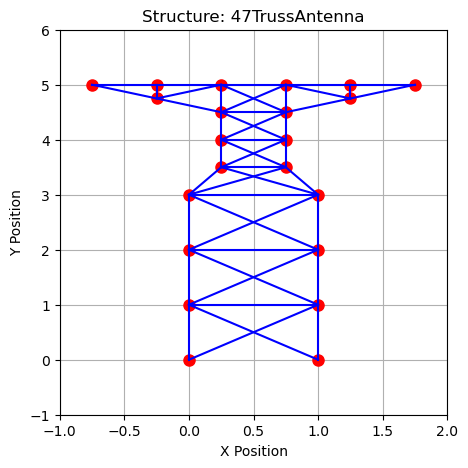

In [6]:
# Create a plot
plt.figure(figsize=(5, 5))
plt.title(f"Structure: {exampleName}")

# Plot nodes
plt.plot(nodeXY[:, 0], nodeXY[:, 1], 'ro', markersize=8)

# Plot elements
for i in range(len(connectivity)):
    node1 = connectivity[i, 0]
    node2 = connectivity[i, 1]
    x = [nodeXY[node1, 0], nodeXY[node2, 0]]
    y = [nodeXY[node1, 1], nodeXY[node2, 1]]
    plt.plot(x, y, 'b')


# Set axis limits
plt.xlim(-1, 2)
plt.ylim(-1, 6)

# Add labels
plt.xlabel('X Position')
plt.ylabel('Y Position')

plt.grid()
plt.show()

# Gets the z coordinates of each material

In [7]:
vae = materialEncoder.vaeNet
#In decoded there are the decoded properties of each material
#decoded = vae.decoder(vae.encoder.z)
#In z_np are the coordinates of each real material in the latent space
z_np = to_np(vae.encoder.z)
#I get the minimum and maximum z to restrict my boundaries of latent space
z0min, z1min = 0.95*np.min(z_np, axis=0)
z0max, z1max = 1.05*np.max(z_np, axis=0)

nprops=len(props)
max_scale = np.empty(nprops)
min_scale = np.empty(nprops)

#Gets minimum and maximum of each property
for p in props:
    idx = materialEncoder.dataInfo[p]['idx']
    max_scale[idx] = materialEncoder.dataInfo[p]['scaleMax']
    min_scale[idx] = materialEncoder.dataInfo[p]['scaleMin']

# Defines objective and constraints

In [8]:
#Defines constraints and objectives
constraints = {'massCons': {'isOn':False, 'maxMass':5}, \
               'costCons': {'isOn':False, 'maxCost':5},\
               'tensionCons': {'isOn':True, 'FOS':4.},\
               'complianceCons': {'isOn':False, 'maxJ':35},\
               'compressionCons': {'isOn':True, 'FOS':4.},\
               'co2Cons': {'isOn':False, 'maxco2':30},\
               'energyCons': {'isOn':False, 'maxenergy' : 1e10},\
               'waterCons': {'isOn':False, 'maxwater':4e3},\
               'confidenceCons': {'isOn':True, 'minconf':93}}


objectives = {'cost': {'isOn':True},\
              'mass': {'isOn':False}, \
              'co2': {'isOn':True},\
              'water': {'isOn':False},\
              'energy': {'isOn':False},\
              'compliance': {'isOn': False}}
               
# count the number of entries with 'isOn' set to True
no = sum(1 for v in objectives.values() if v['isOn'])
nc = sum(1 for v in constraints.values() if v['isOn'])

# print an error message in red if there are 3 or more entries with 'isOn' set to True
if no >= 3:
    print('Error: Two or more entries have isOn=True')

# Defines the problem

In [9]:
import numpy as np
from pymoo.core.problem import ElementwiseProblem

class MyProblem(ElementwiseProblem):

    def __init__(self, truss, z_np, constraints, objectives, no, nc):
        super().__init__(n_var=49,
                         n_obj=no,
                         n_ieq_constr=nc,
                         xl = np.array([z0min, z1min] + [2e-8] * 47),
                         xu = np.array([z0max, z1max] + [2e-3] * 47))

        self.truss=truss
        self.z_np=z_np
        self.constraints=constraints
        self.objectives=objectives


    def _evaluate(self, x, out, *args, **kwargs):

        Z = torch.zeros((1, vaeSettings['encoder']['latentDim']))
        Z[:,0]=x[0]
        Z[:,1]=x[1]

        
        matprop=np.empty(7)
        #Decodes the properties of Z
        decoded = vae.decoder(Z)
        #Scales properties
        for i in range(0,nprops): 
            matprop[i] = 10.**(min_scale[i] + decoded[:,i]*(max_scale[i] - min_scale[i]))
        
        x_tensor = torch.from_numpy(x[2:])
        area = x_tensor * torch.ones((connectivity.shape[0]))   
        u, _, _, _, internalForce = truss.solveFE(E = torch.tensor([matprop[0]]).float(), A=area)
        compliance = truss.computeCompliance(u)
        volume = truss.getVolume(area)
        mass = matprop[2]*volume
        cost = mass*matprop[1]
        co2 = mass*matprop[4]
        energy = mass*matprop[5]        
        water = mass*matprop[6] 

        
        con_values = []
        
        if(constraints['massCons']['isOn']):
            constraints['massCons']['value'] = (mass/constraints['massCons']['maxMass']) - 1.
            con_values.append(constraints['massCons']['value'])

        if(constraints['costCons']['isOn']):
            constraints['costCons']['value'] = (cost/constraints['costCons']['maxCost']) - 1.
            con_values.append(constraints['costCons']['value'])

        if(constraints['tensionCons']['isOn']):
            tensileForce = 0.001+torch.relu(internalForce)
            tensileStress = tensileForce/area
            maxTensileStressExperienced = torch.pow(torch.sum(tensileStress**6), 1./6)*constraints['tensionCons']['FOS']
            constraints['tensionCons']['value'] = (maxTensileStressExperienced/matprop[3]) - 1.
            con_values.append(constraints['tensionCons']['value'])

        if(constraints['complianceCons']['isOn']):
            constraints['complianceCons']['value'] = (compliance/constraints['complianceCons']['maxJ']) - 1.
            con_values.append(constraints['complianceCons']['value'])

        if(constraints['compressionCons']['isOn']):
            compressiveForce = 0.001+torch.relu(-internalForce)
            k = 4. # used in geom factor... see buckling theory
            geomFactor = k*(self.truss.barLength/(np.pi*area))**2
            compressiveStress = compressiveForce*geomFactor
            maxCompressiveStressExperienced = torch.pow(torch.sum(compressiveStress**6), 1./6)*constraints['compressionCons']['FOS']
            constraints['compressionCons']['value'] = (maxCompressiveStressExperienced/matprop[0]) - 1.
            con_values.append(constraints['compressionCons']['value'])

        if(constraints['co2Cons']['isOn']):
            constraints['co2Cons']['value'] = (co2/constraints['co2Cons']['maxco2']) - 1.
            con_values.append(constraints['co2Cons']['value'])

        if(constraints['energyCons']['isOn']):
            constraints['energyCons']['value'] = (energy/constraints['energyCons']['maxenergy']) - 1.
            con_values.append(constraints['energyCons']['value'])

        if(constraints['waterCons']['isOn']):
            constraints['waterCons']['value'] = (water/constraints['waterCons']['maxwater']) - 1.
            con_values.append(constraints['waterCons']['value'])
            
        if(constraints['confidenceCons']['isOn']):
            zData=x[0:2]
            dist= np.linalg.norm(zData- z_np, axis = 1)
            maxDist = np.max(dist)
            distOrder = np.argsort(dist)
            confidence_level = 100.*(1.- (dist[distOrder[0]]/maxDist))
            constraints['confidenceCons']['value'] = 1 - (confidence_level/constraints['confidenceCons']['minconf'])
            con_values.append(constraints['confidenceCons']['value'])        
        
        obj_values = []
        
        if(objectives['cost']['isOn']):
            obj_values.append(cost)
            
        if(objectives['mass']['isOn']):
            obj_values.append(mass)
            
        if(objectives['co2']['isOn']):
            obj_values.append(co2)
            
        if(objectives['water']['isOn']):
            obj_values.append(water)
            
        if(objectives['energy']['isOn']):
            obj_values.append(energy)
            
        if(objectives['compliance']['isOn']):
            obj_values.append(compliance)
            
  

        out["F"] = np.array(obj_values)
        out["G"] = np.array(con_values)        
        

problem = MyProblem(truss, z_np, constraints, objectives, no, nc)

# Defines the problem settings

In [64]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling

#pop_size: Size of initial population
#n_offsprings: The number of offspring generated in each generation of the algorithm. 
#sampling: The sampling method used to generate new individuals in the offspring population.
    #In this case, FloatRandomSampling is used, which generates random floating-point values
    #in the search space to create new individuals.
#crossover: The crossover operator used to create new individuals in the offspring population.
#mutation: The mutation operator used to create new individuals in the offspring population.
#eliminate_duplicates: A flag to indicate whether duplicate individuals should be eliminated from the population or not.
algorithm = NSGA2(
    pop_size=100,
    n_offsprings=20,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)
from pymoo.termination import get_termination
from pymoo.termination.default import DefaultMultiObjectiveTermination

#termination = get_termination("n_gen", 150)

termination = DefaultMultiObjectiveTermination(
    xtol=1e-2,
    cvtol=1e-9,
    ftol=0.1,
    period=10,
    n_max_gen=200,
    n_max_evals=5000
)


# Runs the solver

In [65]:
from pymoo.optimize import minimize
start = time.perf_counter()
res = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)

print('training time : {:.2F} '.format(time.perf_counter() - start))

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |      1 |  0.0934313118 |  1.933195E+03 |             - |             -
     2 |      120 |      1 |  0.000000E+00 |  1.006947E+02 |             - |             -
     3 |      140 |      1 |  0.000000E+00 |  2.384514E+01 |  0.000000E+00 |             f
     4 |      160 |      1 |  0.000000E+00 |  9.0853138169 |  0.000000E+00 |             f
     5 |      180 |      1 |  0.000000E+00 |  4.7441932738 |  0.000000E+00 |             f
     6 |      200 |      1 |  0.000000E+00 |  2.7713954503 |  0.000000E+00 |             f
     7 |      220 |      1 |  0.000000E+00 |  1.7047645360 |  6.433471E+02 |         ideal
     8 |      240 |      1 |  0.000000E+00 |  1.1114940702 |  1.814523E+01 |         ideal
     9 |      260 |      1 |  0.000000E+00 |  0.6824985330 |  0.000000E+00 |             f
    10 |      280 |      1 |  0.000000E+00 |  0.3867530581 |  2.952933E+01 |         ideal

    89 |     1860 |      6 |  0.000000E+00 |  0.000000E+00 |  0.0257021845 |         ideal
    90 |     1880 |      6 |  0.000000E+00 |  0.000000E+00 |  0.0057284968 |             f
    91 |     1900 |      5 |  0.000000E+00 |  0.000000E+00 |  0.0223879660 |             f
    92 |     1920 |      6 |  0.000000E+00 |  0.000000E+00 |  0.0398077128 |             f
    93 |     1940 |      7 |  0.000000E+00 |  0.000000E+00 |  0.0018444042 |             f
    94 |     1960 |      7 |  0.000000E+00 |  0.000000E+00 |  0.0193102491 |         ideal
    95 |     1980 |      7 |  0.000000E+00 |  0.000000E+00 |  0.0062523462 |             f
    96 |     2000 |      8 |  0.000000E+00 |  0.000000E+00 |  0.0309231339 |         ideal
    97 |     2020 |     10 |  0.000000E+00 |  0.000000E+00 |  0.0061479535 |             f
    98 |     2040 |      9 |  0.000000E+00 |  0.000000E+00 |  0.0027845884 |             f
    99 |     2060 |     12 |  0.000000E+00 |  0.000000E+00 |  0.0089811295 |         ideal

   181 |     3700 |      9 |  0.000000E+00 |  0.000000E+00 |  0.0037623621 |             f
   182 |     3720 |     11 |  0.000000E+00 |  0.000000E+00 |  0.0028774926 |             f
   183 |     3740 |     10 |  0.000000E+00 |  0.000000E+00 |  0.0022778650 |             f
   184 |     3760 |      8 |  0.000000E+00 |  0.000000E+00 |  0.0149761261 |         ideal
   185 |     3780 |      7 |  0.000000E+00 |  0.000000E+00 |  0.0549846988 |         ideal
   186 |     3800 |      8 |  0.000000E+00 |  0.000000E+00 |  0.0086964069 |             f
   187 |     3820 |      6 |  0.000000E+00 |  0.000000E+00 |  0.0150259886 |         ideal
   188 |     3840 |      7 |  0.000000E+00 |  0.000000E+00 |  0.0304540220 |         ideal
   189 |     3860 |      7 |  0.000000E+00 |  0.000000E+00 |  0.0011501652 |             f
   190 |     3880 |      7 |  0.000000E+00 |  0.000000E+00 |  0.0480755077 |         ideal
   191 |     3900 |      7 |  0.000000E+00 |  0.000000E+00 |  0.0027145097 |             f

['AISI 4340 norm', 'AISI 1045 CD', 'AISI 4340 norm', 'AISI 1045 CD', 'AISI 4340 norm', 'AISI 1045 CD', 'AISI 1045 CD', 'AISI 4130', 'AISI 4130']


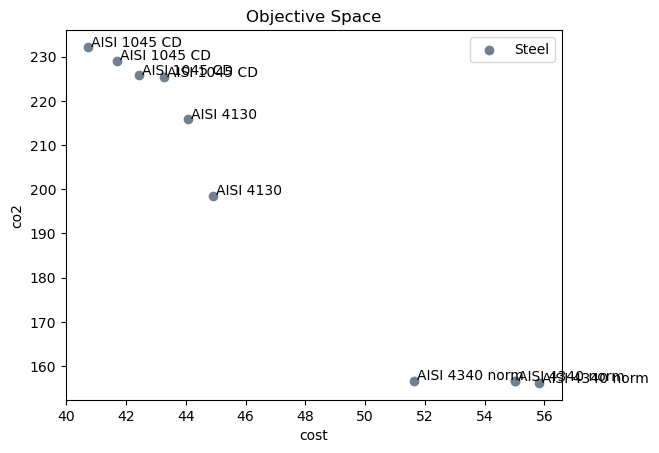

In [66]:
X = res.X
F = res.F
G = res.G


Z_res=X[:,0:2]

names = []
types = []
fig, ax = plt.subplots()
legend_dict = {}



for zData in Z_res:
    dist = np.linalg.norm(zData - z_np, axis=1)
    meanDist = np.max(dist)
    distOrder = np.argsort(dist)
    matname = dataIdentifier['name'][distOrder[0]]
    mattype = dataIdentifier['className'][distOrder[0]]
    names.append(matname)
    types.append(mattype)
    


unique_labels = list(set(types))


# Define specific colors for each material type
mat_colors = {
    'Steel': 'slategrey',
    'Aluminium Alloys': 'violet',
    'Plastics': 'lawngreen',
    'Titanium Alloys': 'indigo',
    'Copper Alloys': 'chocolate',
    'Composites': 'gold',
    # Add more material types and corresponding colors as needed
}

print(names)        
        
# add scatter plot for each unique label
for i, (x, y) in enumerate(F):
    material = names[i]
    mattype = types[i]
    color = mat_colors[mattype]
    label = mattype
    ax.scatter(x, y, color=color, label=label)
    ax.text(x + 0.1, y + 0.1, material)
    if mattype not in legend_dict:
        legend_dict[mattype] = ax.scatter(x, y, color=color, label=label)
#ax.text(20, 19, 'Gray Cast Iron')
#ax.text(25, 7, '1060-H14')
#ax.text(50, 6, 'CFRP')
#ax.text(100, 5, 'CFRP')
        
        
# set legend colors and remove duplicates
handles, labels = [], []
for label in legend_dict:
    handles.append(legend_dict[label])
    labels.append(label)
    legend_dict[label].set_color(mat_colors[label])
    
ax.legend(handles, labels, loc="upper right")

# show plot
plt.title("Objective Space")
entry_order = ['cost', 'mass', 'co2', 'water', 'energy', 'compliance']
enabled_entries = [entry for entry in entry_order if objectives[entry]['isOn']]
ax.set_xlabel(enabled_entries[0])
ax.set_ylabel(enabled_entries[1])
plt.savefig('./figures_Hybrid/Preliminary.png',bbox_inches='tight')
plt.show()

# Re-runs a solver with real materials

In [67]:
# Reduces the database to the groups imvolved
candidate_types1 = list(set(types))

mask = df['class'].isin(candidate_types1)

# Filter the DataFrame using the mask
df2 = df[mask]
df2 = df2.reset_index(drop=True)

dataIdentifier2 = {'name': df2[df2.columns[0]], 'className':df2[df2.columns[1]], 'classID':df2[df2.columns[2]]} # name of the material and type
trainInfo2 = torch.tensor((df2[df2.columns[3:]].to_numpy())).float()

#print(dataIdentifier2)

props = df2.columns[3:].tolist()
nmat, nprop = trainInfo2.size()

In [74]:
import numpy as np
from pymoo.core.problem import ElementwiseProblem
from pymoo.core.variable import Real, Integer, Choice, Binary
from pymoo.termination.default import DefaultMultiObjectiveTermination

class MixedVarsZDT1(ElementwiseProblem):

    def __init__(self, truss, trainInfo2 , constraints, objectives, nc, no, nmat, **kwargs):

        variables = dict()

        variables[f"x01"] = Integer(bounds=(0, nmat-1))

        for k in range(2, 49):
            variables[f"x{k:02}"] = Real(bounds=(2e-8, 2e-3))

        super().__init__(vars=variables, n_obj=no, n_ieq_constr=nc, **kwargs)
        
        self.truss=truss
        self.trainInfo2=trainInfo2
        self.constraints=constraints
        self.objectives=objectives
        
    def _evaluate(self, x, out, *args, **kwargs):
        x = np.array([x[f"x{k:02}"] for k in range(1, 49)])
        
        matprop=trainInfo2[int(x[0]),:]  
        
        x_tensor = torch.from_numpy(x[1:])
        area = x_tensor * torch.ones((connectivity.shape[0]))   
        u, _, _, _, internalForce = truss.solveFE(E = torch.tensor([matprop[0]]).float(), A=area)
        compliance = truss.computeCompliance(u)
        volume = truss.getVolume(area)
        mass = matprop[2]*volume
        cost = mass*matprop[1]
        co2 = mass*matprop[4]
        energy = mass*matprop[5]        
        water = mass*matprop[6] 
        
        
        
        con_values = []
        
        if(constraints['massCons']['isOn']):
            constraints['massCons']['value'] = (mass/constraints['massCons']['maxMass']) - 1.
            con_values.append(constraints['massCons']['value'])

        if(constraints['costCons']['isOn']):
            constraints['costCons']['value'] = (cost/constraints['costCons']['maxCost']) - 1.
            con_values.append(constraints['costCons']['value'])

        if(constraints['tensionCons']['isOn']):
            tensileForce = 0.001+torch.relu(internalForce)
            tensileStress = tensileForce/area
            maxTensileStressExperienced = torch.pow(torch.sum(tensileStress**6), 1./6)*constraints['tensionCons']['FOS']
            constraints['tensionCons']['value'] = (maxTensileStressExperienced/matprop[3]) - 1.
            con_values.append(constraints['tensionCons']['value'])

        if(constraints['complianceCons']['isOn']):
            constraints['complianceCons']['value'] = (compliance/constraints['complianceCons']['maxJ']) - 1.
            con_values.append(constraints['complianceCons']['value'])

        if(constraints['compressionCons']['isOn']):
            compressiveForce = 0.001+torch.relu(-internalForce)
            k = 4. # used in geom factor... see buckling theory
            geomFactor = k*(self.truss.barLength/(np.pi*area))**2
            compressiveStress = compressiveForce*geomFactor
            maxCompressiveStressExperienced = torch.pow(torch.sum(compressiveStress**6), 1./6)*constraints['compressionCons']['FOS']
            constraints['compressionCons']['value'] = (maxCompressiveStressExperienced/matprop[0]) - 1.
            con_values.append(constraints['compressionCons']['value'])

        if(constraints['co2Cons']['isOn']):
            constraints['co2Cons']['value'] = (co2/constraints['co2Cons']['maxco2']) - 1.
            con_values.append(constraints['co2Cons']['value'])

        if(constraints['energyCons']['isOn']):
            constraints['energyCons']['value'] = (energy/constraints['energyCons']['maxenergy']) - 1.
            con_values.append(constraints['energyCons']['value'])

        if(constraints['waterCons']['isOn']):
            constraints['waterCons']['value'] = (water/constraints['waterCons']['maxwater']) - 1.
            con_values.append(constraints['waterCons']['value'])
            
        
        
        obj_values = []
        
        if(objectives['cost']['isOn']):
            obj_values.append(cost)
            
        if(objectives['mass']['isOn']):
            obj_values.append(mass)
            
        if(objectives['co2']['isOn']):
            obj_values.append(co2)
            
        if(objectives['water']['isOn']):
            obj_values.append(water)
            
        if(objectives['energy']['isOn']):
            obj_values.append(energy)
            
        if(objectives['compliance']['isOn']):
            obj_values.append(compliance)
            
  

        out["F"] = np.array(obj_values)
        out["G"] = np.array(con_values)

if(constraints['confidenceCons']['isOn']):
    ncons=nc-1
else:
    ncons=nc

  

problem2 = MixedVarsZDT1(truss, trainInfo2, constraints, objectives, ncons, no, nmat)


    
from pymoo.visualization.scatter import Scatter
from pymoo.algorithms.moo.nsga2 import NSGA2, RankAndCrowdingSurvival
from pymoo.core.mixed import MixedVariableMating, MixedVariableGA, MixedVariableSampling, MixedVariableDuplicateElimination
from pymoo.optimize import minimize

algorithm = NSGA2(pop_size=60,
                  sampling=MixedVariableSampling(),
                  mating=MixedVariableMating(eliminate_duplicates=MixedVariableDuplicateElimination()),
                  eliminate_duplicates=MixedVariableDuplicateElimination(),
                  )

termination=('n_gen', 350)

In [75]:
start = time.perf_counter()
res = minimize(problem2,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)
print('Solver time : {:.2F}'.format(time.perf_counter() - start))

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |       60 |      2 |  0.000000E+00 |  1.060488E+02 |             - |             -
     2 |      120 |      3 |  0.000000E+00 |  3.5412700126 |  0.5449591077 |         ideal
     3 |      180 |      3 |  0.000000E+00 |  0.5849298314 |  0.0787863372 |         ideal
     4 |      240 |      3 |  0.000000E+00 |  0.0156236258 |  0.4183762822 |         ideal
     5 |      300 |      3 |  0.000000E+00 |  0.000000E+00 |  0.2064133627 |         ideal
     6 |      360 |      3 |  0.000000E+00 |  0.000000E+00 |  0.4941890059 |         ideal
     7 |      420 |      3 |  0.000000E+00 |  0.000000E+00 |  0.0108467685 |             f
     8 |      480 |      2 |  0.000000E+00 |  0.000000E+00 |  7.2773729317 |         ideal
     9 |      540 |      2 |  0.000000E+00 |  0.000000E+00 |  0.8815458101 |         ideal
    10 |      600 |      3 |  0.000000E+00 |  0.000000E+00 |  0.1609447178 |         ideal

    89 |     5340 |      2 |  0.000000E+00 |  0.000000E+00 |  0.0287059751 |         ideal
    90 |     5400 |      2 |  0.000000E+00 |  0.000000E+00 |  0.0322018721 |         ideal
    91 |     5460 |      3 |  0.000000E+00 |  0.000000E+00 |  0.1010111344 |         ideal
    92 |     5520 |      3 |  0.000000E+00 |  0.000000E+00 |  0.0110582859 |             f
    93 |     5580 |      3 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
    94 |     5640 |      3 |  0.000000E+00 |  0.000000E+00 |  0.0437721661 |         ideal
    95 |     5700 |      2 |  0.000000E+00 |  0.000000E+00 |  0.0482075456 |         ideal
    96 |     5760 |      2 |  0.000000E+00 |  0.000000E+00 |  0.0182406035 |         ideal
    97 |     5820 |      2 |  0.000000E+00 |  0.000000E+00 |  0.0012882507 |             f
    98 |     5880 |      2 |  0.000000E+00 |  0.000000E+00 |  0.0234050623 |         ideal
    99 |     5940 |      2 |  0.000000E+00 |  0.000000E+00 |  0.0485770483 |         ideal

   181 |    10860 |      3 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
   182 |    10920 |      2 |  0.000000E+00 |  0.000000E+00 |  0.0483350105 |         ideal
   183 |    10980 |      3 |  0.000000E+00 |  0.000000E+00 |  0.0182193110 |         ideal
   184 |    11040 |      3 |  0.000000E+00 |  0.000000E+00 |  0.0429001959 |         ideal
   185 |    11100 |      3 |  0.000000E+00 |  0.000000E+00 |  0.0070017717 |         ideal
   186 |    11160 |      3 |  0.000000E+00 |  0.000000E+00 |  0.0065746004 |         ideal
   187 |    11220 |      2 |  0.000000E+00 |  0.000000E+00 |  0.0562184529 |         ideal
   188 |    11280 |      2 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
   189 |    11340 |      2 |  0.000000E+00 |  0.000000E+00 |  0.0038176534 |         nadir
   190 |    11400 |      3 |  0.000000E+00 |  0.000000E+00 |  0.1200003428 |         ideal
   191 |    11460 |      3 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f

   273 |    16380 |      3 |  0.000000E+00 |  0.000000E+00 |  0.0006749740 |             f
   274 |    16440 |      3 |  0.000000E+00 |  0.000000E+00 |  0.0006749740 |             f
   275 |    16500 |      3 |  0.000000E+00 |  0.000000E+00 |  0.0010840821 |             f
   276 |    16560 |      3 |  0.000000E+00 |  0.000000E+00 |  0.0010840821 |             f
   277 |    16620 |      3 |  0.000000E+00 |  0.000000E+00 |  0.0015731619 |             f
   278 |    16680 |      3 |  0.000000E+00 |  0.000000E+00 |  0.0029700640 |         ideal
   279 |    16740 |      3 |  0.000000E+00 |  0.000000E+00 |  0.0064825085 |         ideal
   280 |    16800 |      3 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
   281 |    16860 |      3 |  0.000000E+00 |  0.000000E+00 |  0.0046922259 |         ideal
   282 |    16920 |      3 |  0.000000E+00 |  0.000000E+00 |  0.0031653890 |         nadir
   283 |    16980 |      3 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f

[{'x01': 4, 'x02': 0.0003595742957426794, 'x03': 8.625854162109533e-05, 'x04': 9.266375972286782e-05, 'x05': 0.000348008612339741, 'x06': 1.9539480059188097e-06, 'x07': 0.0003443846893225863, 'x08': 2.1042895516316422e-05, 'x09': 2.450209103933298e-05, 'x10': 0.00034379403133112706, 'x11': 1.3185059167250012e-07, 'x12': 0.00033604126702317964, 'x13': 3.822374723302222e-07, 'x14': 1.6315381845036005e-06, 'x15': 0.00033320851410554274, 'x16': 5.266878770733916e-05, 'x17': 0.00022244196848620617, 'x18': 4.5533661482157034e-07, 'x19': 4.792527998636438e-06, 'x20': 0.00022349217854076385, 'x21': 0.00014103562644369308, 'x22': 0.0002084798126430805, 'x23': 9.44825335759698e-05, 'x24': 8.712469891140874e-05, 'x25': 0.00022878018820759912, 'x26': 3.897929336221882e-05, 'x27': 0.00016123063292735096, 'x28': 0.00017347510794069862, 'x29': 0.00017953865225744248, 'x30': 0.00014353760352379074, 'x31': 0.00026206622911286874, 'x32': 0.0003149695549948577, 'x33': 6.965833712111021e-06, 'x34': 2.8046

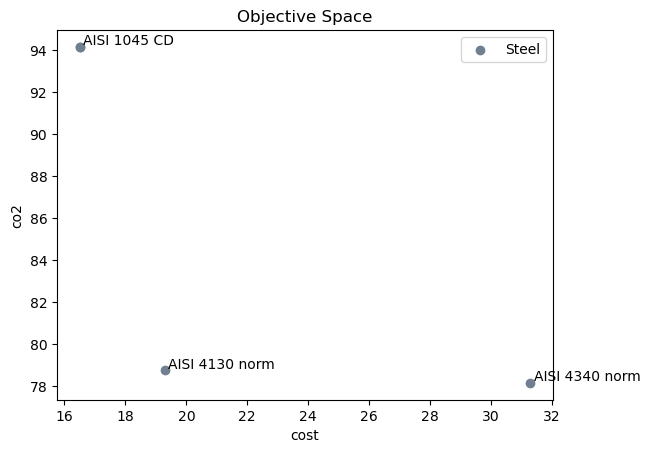

In [76]:
X = res.X
F = res.F
G = res.G
Z_res = [[d['x01']] for d in X]

print(X)


names = []
types = []

fig, ax = plt.subplots()
legend_dict = {}

for xData in Z_res:
    matname = dataIdentifier2['name'][int(xData[0])]
    mattype = dataIdentifier2['className'][int(xData[0])]
    names.append(matname)
    types.append(mattype)
    
unique_labels = list(set(types))

# Define specific colors for each material type
mat_colors = {
    'Steel': 'slategrey',
    'Aluminium Alloys': 'violet',
    'Plastics': 'lawngreen',
    'Titanium Alloys': 'indigo',
    'Copper Alloys': 'chocolate',
    'Composites': 'gold',
    # Add more material types and corresponding colors as needed
}


for i, mattype in enumerate(types):
    if mattype not in mat_colors:
        mat_colors[mattype] = plt.cm.get_cmap('jet')(i / len(set(types)))
        


# add scatter plot for each unique label
for i, (x, y) in enumerate(F):

    material = names[i]
    mattype = types[i]
    color = mat_colors[mattype]
    label = mattype
    ax.scatter(x, y, color=color, label=label)
    ax.text(x + 0.1, y + 0.1, material)
    if mattype not in legend_dict:
        legend_dict[mattype] = ax.scatter(x, y, color=color, label=label)


# set legend colors and remove duplicates
handles, labels = [], []
for label in legend_dict:
    handles.append(legend_dict[label])
    labels.append(label)
    legend_dict[label].set_color(mat_colors[label])
    
ax.legend(handles, labels, loc="upper right")


# show plot
plt.title("Objective Space")
entry_order = ['cost', 'mass', 'co2', 'water', 'energy', 'compliance']
enabled_entries = [entry for entry in entry_order if objectives[entry]['isOn']]
ax.set_xlabel(enabled_entries[0])
ax.set_ylabel(enabled_entries[1])
plt.savefig('./figures_Hybrid/Final',bbox_inches='tight', dpi = 200)
plt.show()


# Defines function to plot the structure

In [77]:
def plot_truss_structure(nodeXY, connectivity, Areas, name):
    # Set maximum thickness for truss members
    max_thickness = 0.02

    # Create plot and axes
    fig, ax = plt.subplots()

    # Plot nodes
    x = [n[0] for n in nodeXY]
    y = [n[1] for n in nodeXY]
    #ax.scatter(x, y, color='black', s=40)

    # Plot truss members
    for i, (n1, n2) in enumerate(connectivity):
        #thickness = min(Areas[i], max_thickness)
        thickness = Areas[i]/max_thickness
        x1, y1 = nodeXY[n1]
        x2, y2 = nodeXY[n2]
        ax.plot([x1, x2], [y1, y2], linewidth=thickness*400, color='black', alpha=0.7)
    
    ax.scatter(x, y, color='gray', s=40, zorder=20)
    # Set axis limits and labels
    ax.set_xlim(min(x)-0.1, max(x)+0.1)
    ax.set_ylim(min(y)-0.1, max(y)+0.1)
    ax.set_xlabel('X position (m)')
    ax.set_ylabel('Y position (m)')
    ax.set_title(f'Truss Structure for {name} solution')

    # Show plot
    plt.savefig(f'./figures/Truss/{name}.png',bbox_inches='tight')
    plt.show()

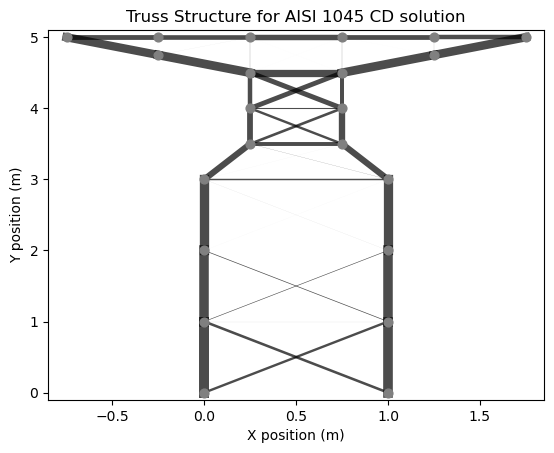

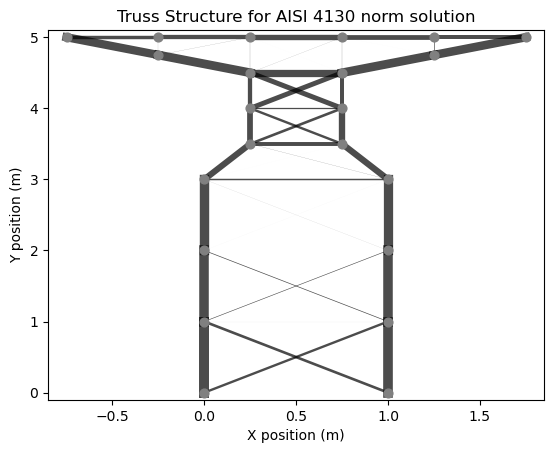

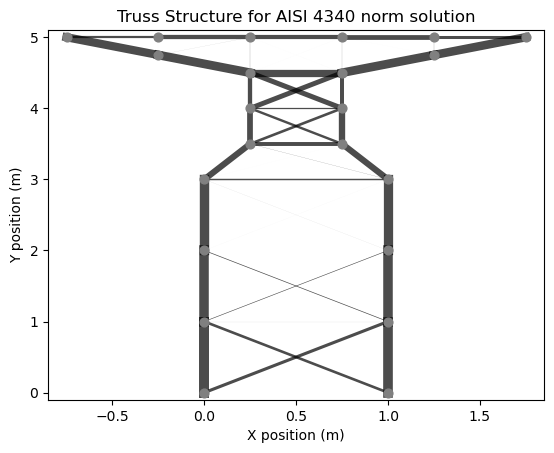

In [78]:
for x in X:
    Areas = [x[f'x{j:02}'] for j in range(2, 49)]
    Material = dataIdentifier2['name'][x[f'x0{1}']]
    plot_truss_structure(nodeXY, connectivity, Areas, Material)